In [15]:
#!pip install gym[atari] gym-super-mario-bros opencv-python torch torchvision tqdm
#!pip uninstall gym
#!pip install "gym==0.25.2"
#!pip install gym_super_mario_bros==7.3.0 #nes-py==8.2.1!


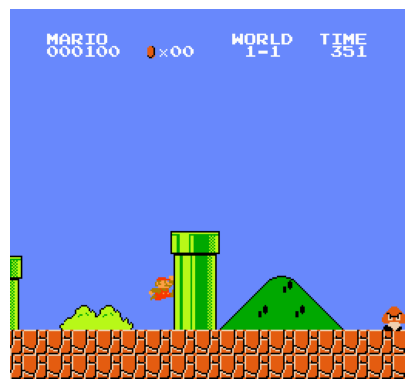

KeyboardInterrupt: 

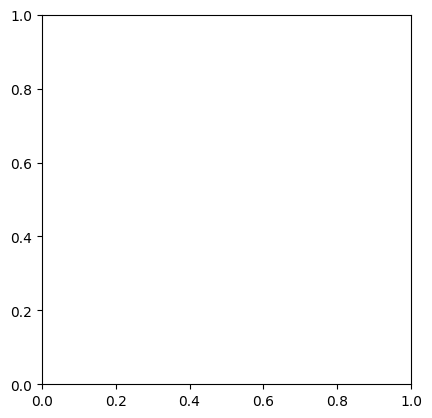

In [28]:
import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Crear el entorno
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# Número de episodios
episodes = 1

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    print(f"Episode {episode + 1} starts!")
    while not done:
        # Renderizar el entorno como una imagen
        frame = env.render(mode='rgb_array')
        plt.imshow(frame)
        plt.axis('off')
        clear_output(wait=True)  # Limpiar la salida anterior
        plt.show()

        # Seleccionar una acción aleatoria
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        total_reward += reward

    print(f"Episode {episode + 1} finished with total reward: {total_reward}")

env.close()

In [32]:
import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import numpy as np
import random

# Crear el entorno
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# Hiperparámetros
alpha = 0.1  # Tasa de aprendizaje
gamma = 0.99  # Factor de descuento
epsilon = 1.0  # Probabilidad de exploración
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 1000

# Discretizar el espacio de estados
state_bins = [10, 10, 10]  # Número de divisiones por dimensión
state_space = tuple(state_bins)
action_space = env.action_space.n
q_table = np.zeros(state_space + (action_space,))

def discretize_state(state):
    """Convierte un estado continuo en un estado discreto."""
    state = state[0]  # Usar solo la posición de Mario (ignorar la imagen completa)
    bins = [
        np.linspace(0, 255, state_bins[0]),  # Discretizar la posición horizontal
        np.linspace(0, 255, state_bins[1]),  # Discretizar la posición vertical
        np.linspace(0, 255, state_bins[2]),  # Discretizar velocidad, etc.
    ]
    return tuple(np.digitize(state, bins[i]) - 1 for i in range(len(bins)))

# Función para elegir una acción (exploración/explotación)
def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Exploración
    return np.argmax(q_table[state])  # Explotación

# Entrenamiento
for episode in range(episodes):
    state = env.reset()
    state = discretize_state(state)
    done = False
    total_reward = 0

    while not done:
        # Elegir acción
        action = choose_action(state, epsilon)

        # Tomar acción y observar el resultado
        next_state, reward, done, info = env.step(action)
        next_state = discretize_state(next_state)

        # Actualizar tabla Q
        best_next_action = np.argmax(q_table[next_state])
        q_table[state][action] = q_table[state][action] + alpha * (
            reward + gamma * q_table[next_state][best_next_action] - q_table[state][action]
        )

        state = next_state
        total_reward += reward

    # Reducir epsilon (menos exploración con el tiempo)
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

env.close()

Episode 1: Total Reward = 139.0
Episode 2: Total Reward = 267.0
Episode 3: Total Reward = 247.0


KeyboardInterrupt: 

In [33]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Crear el entorno
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# Mostrar el agente entrenado
state = env.reset()
state = discretize_state(state)  # Discretizar el estado inicial
done = False
total_reward = 0

print("Mostrando el agente entrenado...")
while not done:
    # Seleccionar la mejor acción usando la tabla Q entrenada
    action = np.argmax(q_table[state])

    # Tomar la acción y renderizar el entorno
    next_state, reward, done, info = env.step(action)
    next_state = discretize_state(next_state)  # Discretizar el próximo estado
    total_reward += reward

    # Renderizar el entorno como una imagen en el notebook
    frame = env.render(mode='rgb_array')
    plt.imshow(frame)
    plt.axis('off')
    clear_output(wait=True)  # Limpiar la salida anterior
    plt.show()

    # Actualizar el estado
    state = next_state

print(f"Total Reward: {total_reward}")
env.close()

KeyboardInterrupt: 

In [31]:
import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Crear el entorno
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# Parámetros de DQN
gamma = 0.99  # Factor de descuento
epsilon = 1.0  # Probabilidad de exploración
epsilon_decay = 0.995
epsilon_min = 0.01
learning_rate = 0.001
episodes = 500
batch_size = 64
memory_size = 10000

# Red neuronal para aproximar la función Q
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Inicializar red neuronal, optimizador y memoria de repetición
state_dim = np.prod(env.observation_space.shape)  # Dimensión del estado (imagen a vector)
action_dim = env.action_space.n  # Número de acciones
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

# Función para seleccionar una acción (exploración/explotación)
def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Exploración
    state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        q_values = policy_net(state)
    return torch.argmax(q_values).item()  # Explotación

# Función para entrenar la red neuronal
def train():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    # Calcular valores Q actuales y objetivos
    q_values = policy_net(states).gather(1, actions).squeeze(1)
    next_q_values = target_net(next_states).max(1)[0]
    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    # Actualizar la red neuronal
    loss = nn.MSELoss()(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Entrenamiento
for episode in range(episodes):
    state = env.reset()
    state = state.flatten()  # Convertir imagen a vector
    done = False
    total_reward = 0

    while not done:
        action = choose_action(state, epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = next_state.flatten()
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        train()

    # Actualizar epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Actualizar red objetivo periódicamente
    if episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

env.close()

C:\Users\yoda\AppData\Local\Temp\ipykernel_17596\3067490711.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  states = torch.FloatTensor(states)


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Crear el entorno
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# Mostrar el agente entrenado
state = env.reset()
state = state.flatten()  # Convertir imagen a vector
done = False
total_reward = 0

print("Mostrando el agente entrenado...")
while not done:
    # Seleccionar la mejor acción usando la red entrenada
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action = torch.argmax(policy_net(state_tensor)).item()

    # Tomar la acción y renderizar el entorno
    next_state, reward, done, info = env.step(action)
    next_state = next_state.flatten()
    total_reward += reward

    # Renderizar el entorno como una imagen en el notebook
    frame = env.render(mode='rgb_array')
    plt.imshow(frame)
    plt.axis('off')
    clear_output(wait=True)  # Limpiar la salida anterior
    plt.show()

    # Actualizar el estado
    state = next_state

print(f"Total Reward: {total_reward}")
env.close()

In [ ]:
https://github.com/yumouwei/super-mario-bros-reinforcement-learning